Loading runs/detect/train20/weights/best.onnx for ONNX Runtime inference...

0: 640x640 4 persons, 48.2ms


2024-11-05 06:24:34.761404269 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2024-11-05 06:24:34.761420089 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


Speed: 2.9ms preprocess, 48.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
[{'xc': np.float32(0.9539098), 'yc': np.float32(0.07792222), 'w': np.float32(0.03801937), 'h': np.float32(0.043775015), 'label': 0, 'score': 0.44769421219825745}, {'xc': np.float32(0.007131617), 'yc': np.float32(0.01979177), 'w': np.float32(0.014093486), 'h': np.float32(0.025942933), 'label': 0, 'score': 0.2929995059967041}, {'xc': np.float32(0.12323799), 'yc': np.float32(0.3126892), 'w': np.float32(0.021117395), 'h': np.float32(0.028120844), 'label': 0, 'score': 0.28653663396835327}, {'xc': np.float32(0.077050954), 'yc': np.float32(0.99214107), 'w': np.float32(0.02230265), 'h': np.float32(0.015717825), 'label': 0, 'score': 0.276330828666687}]


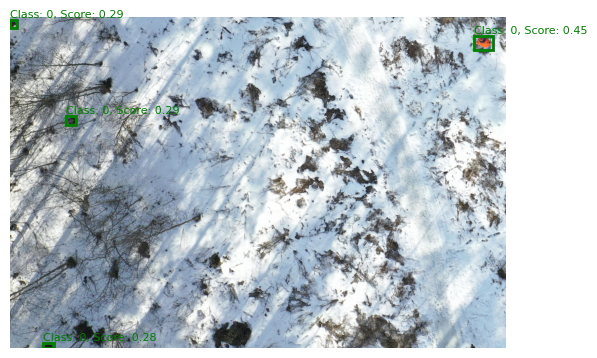

In [17]:
import numpy as np
from typing import List, Union
import torch
import os
import cv2
from ultralytics import YOLO

onnx_model = YOLO("runs/detect/train20/weights/best.onnx", task="detect")

def preprocess_image(image: np.ndarray) -> np.ndarray:
    """Preprocess the image for ONNX model input."""
    # Resize and normalize the image as per model requirements
    img_resized = cv2.resize(image, (640, 640))
    img_normalized = img_resized / 255.0  # normalize to [0, 1]
    img_transposed = np.transpose(img_normalized, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    img_expanded = np.expand_dims(img_transposed, axis=0)  # add batch dimension
    return img_expanded.astype(np.float32)


def infer_image_bbox(image: np.ndarray) -> List[dict]:
    """Функция для получения ограничивающих рамок объектов на изображении.

    Args:
        image (np.ndarray): Изображение, на котором будет производиться инференс.

    Returns:
        List[dict]: Список словарей с координатами ограничивающих рамок и оценками.
        Пример выходных данных:
        [
            {
                'xc': 0.5,
                'yc': 0.5,
                'w': 0.2,
                'h': 0.3,
                'label': 0,
                'score': 0.95
            },
            ...
        ]
    """
    res_list = []
    
    input_tensor = preprocess_image(image)

    result = onnx_model(image)  

    result_numpy = []

    # Преобразуем результаты в numpy массивы
    for res in result:
        result_numpy.append(res.cpu().numpy())

    # Если есть результаты, обрабатываем их
    if len(result_numpy) > 0:
        for res in result_numpy:
            for box in res.boxes:
                xc = box.xywhn[0][0]
                yc = box.xywhn[0][1]
                w = box.xywhn[0][2]
                h = box.xywhn[0][3]
                conf = box.conf[0].item()

                formatted = {
                    'xc': xc,
                    'yc': yc,
                    'w': w,
                    'h': h,
                    'label': 0,
                    'score': conf
                }
                res_list.append(formatted)

    return res_list

def predict(images: Union[List[np.ndarray], np.ndarray]) -> List[List[dict]]:
    """Функция производит инференс модели на одном или нескольких изображениях.

    Args:
        images (Union[List[np.ndarray], np.ndarray]): Список изображений или одно изображение.

    Returns:
        List[List[dict]]: Список списков словарей с результатами предикта
        на найденных изображениях.
    """
    results = []
    if isinstance(images, np.ndarray):
        images = [images]

    # Обрабатываем каждое изображение из полученного списка
    for image in images:
        image_results = infer_image_bbox(image)
        results.append(image_results)

    return results





image = cv2.imread("/home/jovyan/datasets/dataset_yolo_X/images/000005.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bbox_results = infer_image_bbox(image)
print(bbox_results)
image_with_detections = image.copy()
import matplotlib.pyplot as plt
height, width = image.shape[:2]
for detection in bbox_results:
    # Нормированные координаты центра и размеров
    xc_norm = detection['xc']
    yc_norm = detection['yc']
    w_norm = detection['w']
    h_norm = detection['h']

    # Преобразование нормированных координат в пиксельные
    xc = xc_norm * width
    yc = yc_norm * height
    w = w_norm * width
    h = h_norm * height

    # Вычисляем координаты углов рамки
    x_min = xc - (w / 2)
    y_min = yc - (h / 2)
    x_max = xc + (w / 2)
    y_max = yc + (h / 2)

    # Ограничиваем координаты рамки в пределах изображения
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(width, x_max)
    y_max = min(height, y_max)

    # Рисуем рамку
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='green', facecolor='none'))

    # Добавляем текст (например, класс и уверенность)
    label = f"Class: {detection['label']}, Score: {detection['score']:.2f}"
    plt.text(x_min, y_min, label, fontsize=8, color='green', verticalalignment='bottom')

# Отображаем изображение
plt.imshow(image_rgb)
plt.axis('off')  # Скрыть оси
plt.show()